In [39]:
import os
import math
import sys
import numpy as np
import cv2 as cv
from PIL import Image
from matplotlib import pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio

import tensorflow as tf
from tensorflow import keras

from u_net import *

In [3]:
#!git clone https://github.com/nth-eye/Denoiser.git unet

# obtener el dataset urban100
!wget https://data.deepai.org/set5.zip
!unzip -qq set5.zip
!cd set5/
!unzip -qq set5/SR_testing_datasets.zip -d testing
!unzip -qq set5/SR_training_datasets.zip -d training

--2021-05-31 10:21:38--  https://data.deepai.org/set5.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407631796 (389M) [application/x-zip-compressed]
Saving to: ‘set5.zip’

set5.zip            100%[===================>] 388.75M  26.4MB/s    in 15s     

2021-05-31 10:21:54 (25.2 MB/s) - ‘set5.zip’ saved [407631796/407631796]



In [99]:
if not os.path.exists('downsampled'):
    os.makedirs('downsampled')
if not os.path.exists('upsampled'):
    os.makedirs('upsampled')
if not os.path.exists('croppedUrban100'):
  os.makedirs('croppedUrban100')

orig_path = "/content/testing/Urban100"
crop_path = "/content/croppedUrban100"
down_path = "/content/downsampled"
up_path = "/content/upsampled"
n_img = 100

def resize_images():
  for i in range(n_img):
    # leer imagen
    img = cv.imread(f"{orig_path}/img_{str(i+1).zfill(3)}.png")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = img[:256, :256, 1]
    Image.fromarray(img).save(f"{crop_path}/img_{str(i+1).zfill(3)}.png")

# generar los datos para el entrenamiento
def downsample_images(factor):
  print(f"Runing downsampler x{factor}...")
  for i in range(n_img):
    # leer imagen
    img = cv.imread(f"{crop_path}/img_{str(i+1).zfill(3)}.png")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # downsample horizontal
    for j in range(factor):
      img = np.delete(img, range(1, img.shape[0], 2), axis=0)

    # downsample vertical
    for k in range(factor):
      img = np.delete(img, range(1, img.shape[1], 2), axis=1)

    # save image to disk
    Image.fromarray(img).save(f"{down_path}/img_{str(i+1).zfill(3)}.png")
  print(f"Done\n")

# apply bicubic interpolation
def bicubic_interpolation(factor):
  print(f"Runing bicubic interpolator x{factor}...")
  for i in range(n_img):
    img = cv.imread(f"{down_path}/img_{str(i+1).zfill(3)}.png")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    up = img.resize((img.width*(2**factor), img.height*(2**factor)), resample=Image.BICUBIC)
    up.save(f"{up_path}/img_{str(i+1).zfill(3)}.png")

  print(f"Done\n")

In [100]:
# ejecutar interpolacion bicubica
def run_bicubic(factor):
  resize_images()
  downsample_images(factor)
  bicubic_interpolation(factor)

run_bicubic(1)

Runing downsampler x1...
Done

Runing bicubic interpolator x1...
Done



# Load data

In this notebook used flower dataset from google example_images.

In [230]:
# Hiperparámetros
SEED = 44
BATCH_SIZE = 32
EPOCHS = 10
BUFFER_SIZE = 1000
PARALLEL_CALLS = tf.data.experimental.AUTOTUNE
HEIGHT = 256
WIDTH = 256
DEPTH = 1
LERNING_RATE = 0.0015

In [231]:
#DIR = tf.keras.utils.get_file(origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",fname="flower_photos", untar=True)
#FILES = tf.data.Dataset.list_files(DIR+"/*/*", shuffle=False)

FILES = tf.data.Dataset.list_files(f"{crop_path}/*", shuffle=False)
N_ELEMENTS = tf.data.experimental.cardinality(FILES).numpy()

train_size = int(0.8 * N_ELEMENTS)
test_size = int(0.2 * N_ELEMENTS)

# Process and split

In [232]:
def get_bicubic_upscaling(img, factor):

  # downsample
  height = tf.shape(img)[0]
  width = tf.shape(img)[1]
  d_img = tf.image.resize(img, (width // (2**factor), height // (2**factor)), method=tf.image.ResizeMethod.BICUBIC)

  # bicubic interpolation
  height = tf.shape(d_img)[0]
  width = tf.shape(d_img)[1]
  return tf.image.resize(d_img, (width*(2**factor), height*(2**factor)), method=tf.image.ResizeMethod.BICUBIC)
 
def process_fn(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_png(img, channels=DEPTH)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [WIDTH, HEIGHT])
  bicubic = get_bicubic_upscaling(img, 1)

  return bicubic, img

def prepare(dataset):
  dataset = dataset.shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE).prefetch(PARALLEL_CALLS)
  return dataset

dataset = FILES.map(process_fn, num_parallel_calls=PARALLEL_CALLS)
dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = prepare(train_dataset)
test_dataset = prepare(test_dataset)

# Create model

In [233]:
model = UNet([16, 32, 64, 128, 256], 1)

# Metrics and pass functions

In [234]:
loss_obj = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=LERNING_RATE)

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        pred = model(images)
        loss = loss_obj(labels, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

@tf.function
def test_step(images, labels):
    pred = model(images)

    return loss_obj(labels, pred)

# Train

In [235]:
for epoch in range(EPOCHS):
    
    train_loss = 0
    test_loss = 0
    
    for features, labels in train_dataset:
        train_loss += train_step(features, labels)

    for features, labels in test_dataset:
        test_loss += test_step(features, labels)

    print("Epoch {}, Loss: {}, Test Loss: {}"\
          .format(epoch+1, train_loss, test_loss))

Epoch 1, Loss: 0.22801902890205383, Test Loss: 0.07535740733146667
Epoch 2, Loss: 0.21119242906570435, Test Loss: 0.07020752131938934
Epoch 3, Loss: 0.18485553562641144, Test Loss: 0.06610327959060669
Epoch 4, Loss: 0.17482993006706238, Test Loss: 0.053042422980070114
Epoch 5, Loss: 0.13270127773284912, Test Loss: 0.030531475320458412
Epoch 6, Loss: 0.11174845695495605, Test Loss: 0.027995001524686813
Epoch 7, Loss: 0.07151680439710617, Test Loss: 0.01118171215057373
Epoch 8, Loss: 0.05627772584557533, Test Loss: 0.012534171342849731
Epoch 9, Loss: 0.04096473008394241, Test Loss: 0.007288740482181311
Epoch 10, Loss: 0.030169446021318436, Test Loss: 0.00841465499252081


# Results

In [237]:
# calculate mse, psnr and ssim
def calculate_errors(orig, up):
  print(f"calculating errors...")

  results = {
      'mse': [],
      'psnr': [],
      'ssim': [],
  }

  for i in range(len(orig)):
    img_orig = np.squeeze(orig[i])
    img_up = np.squeeze(up[i])

    mse_val = mean_squared_error(img_orig, img_up)
    psnr_val = peak_signal_noise_ratio(img_orig, img_up, data_range=img_up.max() - img_up.min())
    ssim_val = structural_similarity(img_orig, img_up, data_range=img_up.max() - img_up.min(), multichannel=True)

    results['mse'].append(mse_val)
    results['psnr'].append(psnr_val)
    results['ssim'].append(ssim_val)

  return results

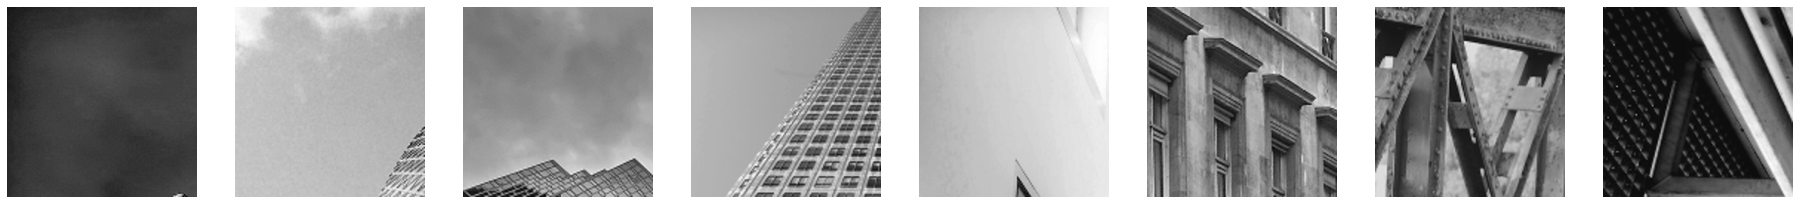

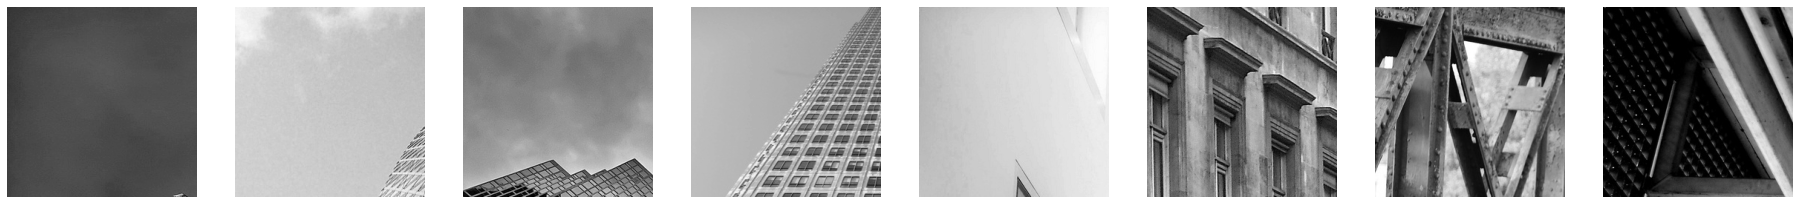

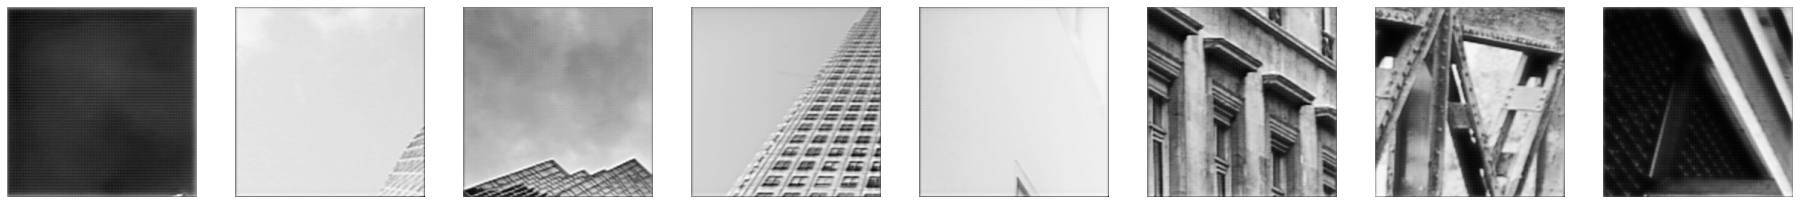

In [238]:
def show(image_batch):
    plt.figure(figsize=(32,8))
    for n in range(8):
        plt.subplot(1,8,n+1)
        plt.imshow(np.squeeze(image_batch[n]), cmap="gray")
        plt.axis("off")
        
images, labels = next(iter(test_dataset))
results = model(images)

show(images)
show(labels)
show(results)

In [260]:

plt.imsave('/content/output/img_low_5.png', np.squeeze(images[5]), cmap="gray")
plt.imsave('/content/output/img_orig_5.png', np.squeeze(labels[5]), cmap="gray")
plt.imsave('/content/output/img_high_5.png', np.squeeze(results[5]), cmap="gray")

plt.imsave('/content/output/img_low_3.png', np.squeeze(images[3]), cmap="gray")
plt.imsave('/content/output/img_orig_3.png', np.squeeze(labels[3]), cmap="gray")
plt.imsave('/content/output/img_high_3.png', np.squeeze(results[3]), cmap="gray")

In [240]:
print( np.array(all_errors['ssim']).mean() )
print( np.array(all_errors['psnr']).mean() )

0.6574055616318598
18.852717945709877


calculating errors...


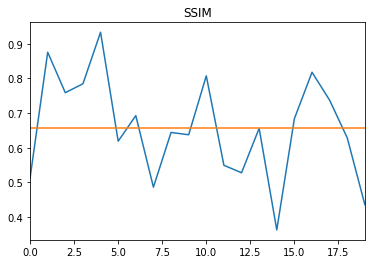

In [239]:
all_errors = calculate_errors(labels, results)

plt.title('SSIM')
plt.plot(range(len(images)), all_errors['ssim'], label='SSIM')
plt.xlim([0, 19])
plt.plot(range(len(images)), np.array(all_errors['ssim']).mean().repeat(len(images)), label='SSIM')
plt.show()

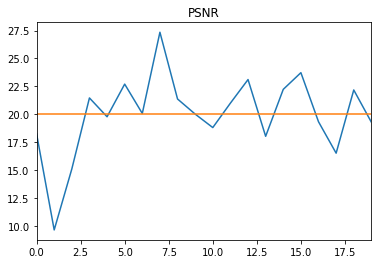

In [178]:
plt.title('PSNR')
plt.plot(range(len(images)), all_errors['psnr'], label='PSNR')
plt.xlim([0, 19])
plt.plot(range(len(images)), np.array(all_errors['psnr']).mean().repeat(len(images)), label='PSNR')
plt.show()

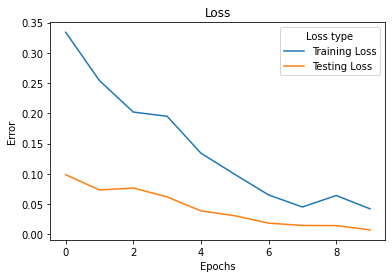

In [271]:
loss_data = {'train_loss': [0.334, 0.254, 0.202, 0.195, 0.134, 0.099, 0.065, 0.045, 0.064, 0.042], 'test_loss': [0.0984, 0.0732, 0.0764, 0.0616, 0.0386, 0.0305, 0.0183, 0.0145, 0.0142, 0.0071] }

plt.title('Loss')
plt.plot(range(len(loss_data['train_loss'])), loss_data['train_loss'], label='Training Loss')

plt.plot(range(len(loss_data['train_loss'])), loss_data['test_loss'], label='Testing Loss')

plt.ylabel("Error")
plt.xlabel("Epochs")
plt.legend(title='Loss type')

plt.show()
